![](../reports/presentations/20231205/1.png)

# Pipeline

## Overview

![](../reports/presentations/20231205/2.png)
![](../reports/presentations/20231205/3.png)
![](../reports/presentations/20231205/4.png)

## Preprocessing
#### Tasks:
- text transformation (is the data available in the needed format or does it need
to be transformed or even generated in that format?)
- text cleaning (e.g. remove stop words, lemmatize)
- extraction of desired information (e.g. sentences, noun phrases, certain
entities, activities of a process)
- feature engineering (e.g. are features highly correlated and can be combined?; is
a combination of certain features more insightful for given problem?)
- feature enrichment (are there additional features that are not included in the
data but seem necessary/advantageous to include?; can these be collected or generated?)

### Formatting

In [2]:
# External imports
import os
import sys
import spacy


# Get the current working directory (assuming the notebook is in the notebooks folder)
current_dir = os.getcwd()

# Add the parent directory (project root) to the Python path
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

# Relative imports
from src.preprocess import txt_to_df, rmv_and_rplc, chng_stpwrds, lmtz_and_rmv_stpwrds
from src.modelling import gt_mtchs
from src.utils import prnt_brk
from src.evaluation import cnstrnts_gs, sbert_smlarty, sbert_smlarty_cmpntns, evlt_prec_rec

In [3]:
# Define variables to use as keys
aktg = "AktG"
cdm_01 = "CDM 01: A/R Mangroves"
cdm_02 = "CDM 02: A/R Non-wetlands"
cdm_03 = "CDM 03: Cable Cars"
cdm_04 = "CDM 04: Energy Efficiency"
cdm_05 = "CDM 05: Electriciy Generation"
coffee = "Coffee"
patg = "PatG"

# Define file paths
file_paths_input = {
    aktg: os.path.join('..', 'data', 'aktg', 'input_aktg.txt'),
    cdm_01: os.path.join('..', 'data', 'cdm', 'input_cdm_01.txt'),
    cdm_02: os.path.join('..', 'data', 'cdm', 'input_cdm_02.txt'),
    cdm_03: os.path.join('..', 'data', 'cdm', 'input_cdm_03.txt'),
    cdm_04: os.path.join('..', 'data', 'cdm', 'input_cdm_04.txt'),
    cdm_05: os.path.join('..', 'data', 'cdm', 'input_cdm_05.txt'),  
    coffee: os.path.join('..', 'data', 'coffee', 'input_coffee.txt'),
    patg: os.path.join('..', 'data', 'patg', 'input_patg.txt'),  
}

file_paths_output = {
    aktg: os.path.join('..', 'data', 'aktg', 'output_aktg.txt'),
    cdm_01: os.path.join('..', 'data', 'cdm', 'output_cdm_01.txt'),
    cdm_02: os.path.join('..', 'data', 'cdm', 'output_cdm_02.txt'),
    cdm_03: os.path.join('..', 'data', 'cdm', 'output_cdm_03.txt'),
    cdm_04: os.path.join('..', 'data', 'cdm', 'output_cdm_04.txt'),
    cdm_05: os.path.join('..', 'data', 'cdm', 'output_cdm_05.txt'),  
    coffee: os.path.join('..', 'data', 'coffee', 'output_coffee.txt'),
    patg: os.path.join('..', 'data', 'patg', 'output_patg.txt'),  
}

In [3]:
# # Split text into columns
# data = {key: txt_to_df(path) for key, path in file_paths_input.items()}

# data[coffee]

,Section,Raw,Processed
0,,<!--\n\tSources used for this handbook:\n\t\t-...,
1,Coffee Roasting Handbook 1st Edition Exclusive:,,
2,About our Coffee:,\nWe roast our own coffee in the coffeehouse o...,
3,Controls and Basic Settings:,,
4,Controls and Basic Settings:/Power Switch:,\nThe power switch is the upper-left knob on t...,
5,Controls and Basic Settings:/Heater Control:,\nThe knob at the bottom-left of the control p...,
6,Controls and Basic Settings:/Ammeter:,\nThe ammeter is on the upper-left of the cont...,
7,Controls and Basic Settings:/Blower Control:,\nThe blower is multi-purpose; it moves air th...,
8,Controls and Basic Settings:/Thermometer:,\nThe bean temperature displayed on the thermo...,
9,Controls and Basic Settings:/Circuit Breaker:,\nThe circuit breaker is at the roaster’s back...,


In [4]:
# print(data[coffee].iloc[14].Raw)


In general, we first distinguish between three roasting degrees: light, medium and dark. Secondly, we have acknowledge the coffee pile height in the tray as that play a big role in the temperature of the roasting ovens which are the third and last constraint that needs to be abided to.

For better understanding, we describe temperature rules with boundary temperatures t_min and t_max and distinguish between:
	-> open brackets, e.g., (t_min, t_max), this means that the boundary temperatures ARE NOT included in the rules.
	-> closed brackets, e.g., [t_min, t_max], this means that the boundary temperatures ARE included in the rules.

	-> Light Roast:
	Goes through roasting oven 1,2 and 3.
	Light roasts are light brown with no oil on the bean surface, with a toasted grain taste and noticeable acidity. A common misconception is that Light Roasts don’t have as much caffeine as their darker, bolder counterparts. However, the truth is exactly the opposite! As beans roast, the caffeine slowly 

### Cleaning

#### Remove intends and specific literals

In [5]:
# remove = ["\n", "\t","-->", "->"]
# replace = {}

# for case, df in data.items():
#     data[case].Processed = data[case].Raw.apply(rmv_and_rplc, remove=remove, replace=replace)

In [6]:
# text = data[coffee].iloc[14].Processed
# print(text)

 In general, we first distinguish between three roasting degrees: light, medium and dark. Secondly, we have acknowledge the coffee pile height in the tray as that play a big role in the temperature of the roasting ovens which are the third and last constraint that needs to be abided to.  For better understanding, we describe temperature rules with boundary temperatures t_min and t_max and distinguish between:    open brackets, e.g., (t_min, t_max), this means that the boundary temperatures ARE NOT included in the rules.    closed brackets, e.g., [t_min, t_max], this means that the boundary temperatures ARE included in the rules.     Light Roast:  Goes through roasting oven 1,2 and 3.  Light roasts are light brown with no oil on the bean surface, with a toasted grain taste and noticeable acidity. A common misconception is that Light Roasts don’t have as much caffeine as their darker, bolder counterparts. However, the truth is exactly the opposite! As beans roast, the caffeine slowly coo

#### Define stop words

In [7]:
# # Define custom stop words
# add_stpwrds = []
# non_stpwrds = [
#     "above",
#     "all",
#     "and",
#     "at",
#     "before",
#     "below",
#     "between",
#     "both",
#     "can",
#     "else",
#     "even",
#     "for",
#     "if",
#     "last",
#     "least",
#     "less",
#     "must",
#     "next",
#     "no",
#     "none",
#     "not",
#     "nothing",
#     "only",
#     "otherwise",
#     "over",
#     "or",
#     "should",
#     "than",
#     "then",
#     "to",
#     "up"
# ]

# # Add and remove custom stop words globally to the spacy.util.get_lang_class('en')
# stpwrds = chng_stpwrds(add=add_stpwrds,remove=non_stpwrds, remove_numbers=True,verbose=True)

# # Uncomment this line to restore the default set of stpwrds
# # stpwrds = chng_stpwrds(restore_default=True, verbose=True)

eight successfuly added to removal list!
eleven successfuly added to removal list!
fifteen successfuly added to removal list!
fifty successfuly added to removal list!
first successfuly added to removal list!
five successfuly added to removal list!
forty successfuly added to removal list!
four successfuly added to removal list!
hundred successfuly added to removal list!
nine successfuly added to removal list!
one successfuly added to removal list!
six successfuly added to removal list!
sixty successfuly added to removal list!
ten successfuly added to removal list!
third successfuly added to removal list!
three successfuly added to removal list!
twelve successfuly added to removal list!
twenty successfuly added to removal list!
two successfuly added to removal list!
Stop word [ above ] successfully removed!
Stop word [ all ] successfully removed!
Stop word [ and ] successfully removed!
Stop word [ at ] successfully removed!
Stop word [ before ] successfully removed!
Stop word [ below ] s

#### Remove stop words and lemmatize

In [8]:
# for case, df in data.items():
#     df['Doc'] = df['Processed'].apply(lmtz_and_rmv_stpwrds, model='en_core_web_lg', verbose=True)

< ! --   Sources used for this handbook :      Employee Handbook Coffeehouse Five , 323 Market Plaza Greenwood , IN 46142 , 317.300.4330      Quest Coffee Roaster Handbook , First Edition April 2021 , amended May 2021      Copper Moon Coffee , https://www.coppermooncoffee.com/blogs/newsroom/what-is-the-difference-between-light-medium-and-dark-roast-coffee   >
< ! --   source use for handbook :      Employee Handbook Coffeehouse Five , 323 Market Plaza Greenwood , 46142 , 317.300.4330      Quest Coffee Roaster Handbook , First Edition April 2021 , amend May 2021      Copper Moon Coffee , https://www.coppermooncoffee.com/blogs/newsroom/what-is-the-difference-between-light-medium-and-dark-roast-coffee   >


 

We roast our own coffee in the coffeehouse on a weekly basis .
roast coffee coffeehouse weekly basis .

There are two primary things to know about our coffee roasting : where we get our beans and how we roast them .
two primary thing to know coffee roasting : bean and roast .

Coffe

## Modelling
#### Tasks:
- rule based entity matching
- extraction of process steps, variables and constraints
- formatting to fit into desired output

### Extracting process steps and variables

In [10]:
# process_steps, variables = (), ()

# # TODO: Extraction of process steps
# # Summarisation libraries

# # TODO: Extraction of variables ?

### Extracting constraints

In [11]:
# text = data[cdm_ren].iloc[2].Doc
# prnt_brk(text,linebreak=100)

  to validate applicability project activity , organisation need to follow specific evaluation proce
dure . if fail one step , evaluation procedure terminate result non - applicability and methodology 
shall not apply .    first , shall evaluate if project involve new installation or if project replac
e exist onsite fossil - fuel - fire generation . if one condition hold true , next step to check if 
grid connection present or present at time crediting period . if unit to supply electricity newly co
nnect to grid at time crediting period , evaluation procedure terminate result non - applicability .
   if project not limit to supply individual household stand - electricity system involve household 
grid connection prior to project activity , need to evaluate if one following three exception hold t
rue .    ( 1 ) sum instal capacity all renewable energy unit connect to grid supply household less t
han 15 MW .   ( 2 ) project involve renewable energy - base lighting application and emissi

In [24]:
# # TODO: Define more patterns

# pattern = [
#     {"LEMMA": "great"},
#     {"LEMMA": "than"}
# ]

# pattern_name = "GREATER_THAN"

# # TODO: Generalize gt_mtchs to hold multiple patterns

# matches = gt_mtchs(text, pattern, pattern_name)

[(14628693206119734160, 329, 331), (14628693206119734160, 349, 351)]
Match: 14628693206119734160 329 331
Span: great than
Context: project activity great than 4 w
Match: 14628693206119734160 349 351
Span: great than
Context: power plant great than 4 w


In [ ]:
"""
Suggestions for patterns:

01. Requirements keywords: shall, should, must, duties, requirements, require, condition, constraint
02. Numerical value (in combination with unit)
03. Conditional statement keywords: if, then, else, otherwise, case, and, or
04. Comparison keywords: greater than, below, between
05. Comparison operators: <, >, >=, <=, !=, ==
"""

In [25]:
# TODO: Transform matches into formalized structure

# TODO: Compose process steps, variables and matches into constraints

In [11]:
constraints_dummy_cdm = {
    # Exact match
    "c1": "({check project type}, {check connection type}, {directly follows}, {project type == new installation OR project type == replacing existing fossil-fuel-fired generation})",
    # Close match
    "c2": "({check power plant type}, {check hydro power plant}, {directly follows}, {power plant type == hydro power})",
    # No match
    "c3": "({check combustion}, {check emissions}, {directly follows}, {fuel == coal})"
}
constraints_dummy_cdm = {
    'c1': '({check project type}, {check connection type}, {directly follows}, {project_type == new_installation OR project_type == replacing_fossil_fuel})',
    'c2': '({check connection type}, {evaluate grid connection exceptions}, {directly follows}, {grid_connection == True})',
    'c3': '({evaluate grid connection exceptions}, {check hydro power generation}, {directly follows}, {installed_capacity < 15 MW AND exception_1} OR {emission_reduction < 5 tonnes CO2e/year AND exception_2} OR {grid_availability < 36 hours/month AND grid_coverage < 50% AND exception_3})',
    'c4': '({check hydro power generation}, {evaluate hydro power conditions}, {directly follows}, {hydro_power == True})',
    'c5': '({evaluate hydro power conditions}, {check cogeneration system involvement}, {directly follows}, {reservoir_change == no_change} OR {reservoir_change == volume_increase AND power_density > 4 W/m^2} OR {reservoir_change == new_reservoir AND power_density > 4 W/m^2})',
    'c6': '({check cogeneration system involvement}, {evaluate renewable and non-renewable components}, {directly follows}, {cogeneration_system == False})',
    'c7': '({evaluate renewable and non-renewable components}, {check retrofit or replacement}, {directly follows}, {component_type == renewable AND installed_capacity < 15 MW})',
    'c8': '({check retrofit or replacement}, {evaluate addition to existing facility}, {directly follows}, {retrofit_replacement == True AND installed_capacity < 15 MW})',
    'c9': '({evaluate addition to existing facility}, {terminate with applicability}, {directly follows}, {additional_units == False} OR {additional_units == True AND installed_capacity < 15 MW})',
    'c10': '({check hydro power generation}, {terminate with non-applicability}, {directly follows}, {hydro_power == False})',
    'c11': '({evaluate renewable and non-renewable components}, {terminate with non-applicability}, {directly follows}, {component_type == non-renewable OR installed_capacity >= 15 MW})'
  }

## Evaluation
#### Tasks:
- similarity scores of word embeddings of constraints
- final score

### Calculating similarity scores

In [12]:
# Define file paths
file_paths_gs = {
    coffee: os.path.join('..', 'data', 'coffee', 'output-coffee.txt'),
    cdm_05: os.path.join('..', 'data', 'cdm', 'output_cdm_05.txt'),     
}

# Transform content to dictionary
constraints_gs_cdm = cnstrnts_gs(file_paths_gs[cdm_05])
constraints_gs_cdm

{'c1': '({check project type}, {check connection type}, {directly follows}, {project type == new installation OR project type == replacing existing fossil-fuel-fired generation})',
 'c2': '({check connection type}, {check power plant type}, {directly follows}, {connection type == limited to supplying individual households with stand-alone electricity systems AND connection type != new grid connections planned at any time during the crediting period})',
 'c3': '({check connection type}, {check grid exceptions}, {directly follows}, {connection type != limited to supplying individual households with stand-alone electricity systems AND connection type != new grid connections planned at any time during the crediting period})',
 'c4': '({check grid exceptions}, {check power plant type}, {directly follows}, {sum of installed capacities of all renewable energy units < 15 MW OR (project involves renewable energy-based lighting applications AND emission reductions per system < 5 tonnes of CO2e a

In [13]:
similarity_scores = sbert_smlarty(constraints_dummy_cdm, constraints_gs_cdm, model='all-mpnet-base-v2')

for key, value in similarity_scores.items():
    print(f'{key}: {value}')

c1 - c1: 0.8472763895988464
c1 - c2: 0.3754154443740845
c1 - c3: 0.36235228180885315
c1 - c4: 0.22660604119300842
c1 - c5: 0.3995325565338135
c1 - c6: 0.3661043345928192
c1 - c7: 0.296034574508667
c1 - c8: 0.3640923500061035
c1 - c9: 0.403150737285614
c1 - c10: 0.2895858883857727
c1 - c11: 0.22886338829994202
c1 - c12: 0.697838544845581
c1 - c13: 0.39183759689331055
c1 - c14: 0.2087244987487793
c1 - c15: 0.25539177656173706
c1 - c16: 0.29287028312683105
c1 - c17: 0.23617610335350037
c1 - c18: 0.3408185839653015
c1 - c19: 0.2576042413711548
c2 - c1: 0.4191133379936218
c2 - c2: 0.46861201524734497
c2 - c3: 0.6166157722473145
c2 - c4: 0.41430234909057617
c2 - c5: 0.2733701467514038
c2 - c6: 0.2959620952606201
c2 - c7: 0.2345086932182312
c2 - c8: 0.21672388911247253
c2 - c9: 0.28435277938842773
c2 - c10: 0.2281787395477295
c2 - c11: 0.20246011018753052
c2 - c12: 0.3326122760772705
c2 - c13: 0.7267645001411438
c2 - c14: 0.3886107802391052
c2 - c15: 0.22390973567962646
c2 - c16: 0.1779095679

In [14]:
matches_step_1, matches_step_2, matches_constraints = sbert_smlarty_cmpntns(similarity_scores, constraints_dummy_cdm, constraints_gs_cdm, threshold=0.5, model='paraphrase-MiniLM-L6-v2', matching_mode='unique')

In [15]:
matches_step_1

,Constraint pair,Group similarity,From,To,Similarity
0,c5 - c7,0.902067,evaluate hydro power conditions,check hydro power plant conditions,0.829142
1,c11 - c17,0.872841,evaluate renewable and non-renewable components,check non-renewable components,0.840885
2,c7 - c18,0.853839,evaluate renewable and non-renewable components,check retrofit or replacement,0.283560
3,c1 - c1,0.847276,check project type,check project type,1.000000
4,c3 - c4,0.765509,evaluate grid connection exceptions,check grid exceptions,0.813054
5,c4 - c6,0.741681,check hydro power generation,check power plant type,0.656034
6,c2 - c13,0.726765,check connection type,check connection type,1.000000
7,c6 - c8,0.710935,check cogeneration system involvement,check heat and power cogeneration,0.526593
8,c8 - c10,0.697596,check retrofit or replacement,check retrofit or replacement,1.000000
9,c9 - c19,0.691908,evaluate addition to existing facility,check existing renewable electricity generatio...,0.512752


In [16]:
matches_step_2

,Constraint pair,Group similarity,From,To,Similarity
0,c5 - c7,0.902067,check cogeneration system involvement,check heat and power cogeneration,0.526593
1,c11 - c17,0.872841,terminate with non-applicability,non-applicability,0.511229
2,c7 - c18,0.853839,check retrofit or replacement,non-applicability,0.152096
3,c1 - c1,0.847276,check connection type,check connection type,1.000000
4,c3 - c4,0.765509,check hydro power generation,check power plant type,0.656034
5,c4 - c6,0.741681,evaluate hydro power conditions,check hydro power plant conditions,0.829142
6,c2 - c13,0.726765,evaluate grid connection exceptions,non-applicability,0.128223
7,c6 - c8,0.710935,evaluate renewable and non-renewable components,check non-renewable components,0.840885
8,c8 - c10,0.697596,evaluate addition to existing facility,check existing renewable electricity generatio...,0.512752
9,c9 - c19,0.691908,terminate with applicability,non-applicability,0.475329


In [17]:
matches_constraints

,Constraint pair,Group similarity,From,To,Similarity
0,c5 - c7,0.902067,reservoir_change == no_change} OR {reservoir_c...,(reservoir == existing AND volume of reservoir...,0.646967
1,c11 - c17,0.872841,component_type == non-renewable OR installed_c...,(electricity generation unit added == both ren...,0.696480
2,c7 - c18,0.853839,component_type == renewable AND installed_capa...,((implementation for existing renewable electr...,0.590367
3,c1 - c1,0.847276,project_type == new_installation OR project_ty...,project type == new installation OR project ty...,0.867589
4,c3 - c4,0.765509,installed_capacity < 15 MW AND exception_1} OR...,sum of installed capacities of all renewable e...,0.562358
5,c4 - c6,0.741681,hydro_power == True,power plant type == hydro power plant,0.692638
6,c2 - c13,0.726765,grid_connection == True,connection type == new grid connections planne...,0.634880
7,c6 - c8,0.710935,cogeneration_system == False,system != combined heat and power cogeneration,0.637375
8,c8 - c10,0.697596,retrofit_replacement == True AND installed_cap...,((implementation for existing renewable electr...,0.616681
9,c9 - c19,0.691908,additional_units == False} OR {additional_unit...,implementation for existing renewable electric...,0.580143


### Calculating final score

Precision: 0.19556139490821145
Maximum precision: 1.0
Recall: 0.11321975494685926
Maximum recall: 0.5789473684210527
Plot saved at: /Users/leoh/workspace/git/nlp-rule-extraction/notebooks/plots/precision_recall_curves_20240108_202544.png


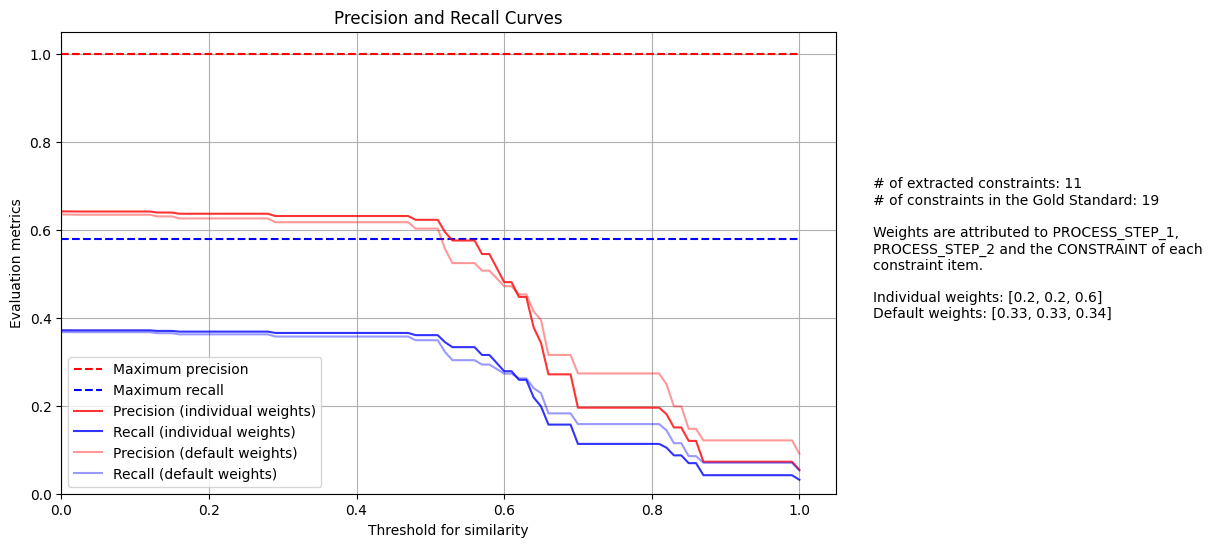

In [18]:
evlt_prec_rec(constraints_dummy_cdm, constraints_gs_cdm, matches_step_1, matches_step_2, matches_constraints, individual_weights=True, weights=[0.2, 0.2, 0.6], hard_cut=True, threshold=0.8, plot_curves=True)

## Next steps


![](../reports/presentations/20231205/5.png)
![](../reports/presentations/20231205/6.png)

Rule based extraction of process steps?

A: 

Relevance of negated constraints?

A: 


Specifics of the calculation of similarity scores?
    
Threshold

A:

"directly follows"

A:

Structure

A:

Calculation of final score?

A:

Literature recommendations? 

A:


![](../reports/presentations/20231205/7.png)